In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import pygad

import HydroErr

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 559

# training hyperparameters
EPOCHS = 500
TRAIN_YEAR = 19
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
embedding = torch.load("data/final_lstm_embedding2.pt", map_location=torch.device('cpu')).to(computing_device)
decoder = torch.load("data/final_lstm_decoder2.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [4]:
dtrain_val = dataloader.Forcing_Data(
    "data/camels_train_val.csv",
    record_length=3652,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

# dtrain = dataloader.Forcing_Data(
#     "camels_train.csv",
#     record_length=2922,
#     storge_device=storge_device,
#     seq_length=SEQ_LENGTH,
#     target_seq_length=TARGET_SEQ_LENGTH,
#     base_length=BASE_LENGTH,
# )

# dval = dataloader.Forcing_Data(
#     "camels_val.csv",
#     record_length=1095,
#     storge_device=storge_device,
#     seq_length=SEQ_LENGTH,
#     target_seq_length=TARGET_SEQ_LENGTH,
#     base_length=BASE_LENGTH,
# )

dtest = dataloader.Forcing_Data(
    "data/camels_test.csv",
    record_length=4383,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [5]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        code = code.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(code, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        if return_summary:
          gof = self.eval_fun(simulated_array=pred, observed_array=ob)
          return gof
        else:
          return pred, ob

In [6]:
num_generations = 200
num_parents_mating = 10

sol_per_pop = 100
num_genes = LATENT_dim

init_range_low = catchment_embeddings.detach().cpu().min().numpy().tolist()
init_range_high = catchment_embeddings.detach().cpu().max().numpy().tolist()

parent_selection_type = "sss"

crossover_type = "single_point"

mutation_type = "random"
mutation_probability = 0.25

x_batch_train_val, y_batch_train_val = dtrain_val.get_val_batch()
x_batch_test, y_batch_test = dtest.get_val_batch()

def evaluate_calibration(selected_catchment=0):
    
    x = x_batch_train_val[:,selected_catchment,:,:]
    y = y_batch_train_val[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    def fitness_func(ga_instance, solution, solution_idx):
        return fn.eval(solution)

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        init_range_low=init_range_low,
                        init_range_high=init_range_high,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_probability = mutation_probability,
                        stop_criteria=["saturate_10"])

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    # evaluate on test dataset
    x = x_batch_test[:,selected_catchment,:,:]
    y = y_batch_test[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    return fn.eval(solution), solution

In [7]:
N_CATCHMENTS = 559
calibrated_KGES = np.ones(N_CATCHMENTS)
camels_embeddings = np.ones([N_CATCHMENTS, LATENT_dim])

for i in range(N_CATCHMENTS):
    print(f'i={i} starts')
    calibrated_KGES[i], camels_embeddings[i,:]  = evaluate_calibration(i)
    print(f'fit={calibrated_KGES[i]}')

i=0 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3287 3288 3289 3290 3291 3292 3293 3294 3295 3296 3297 3298 3299 3300
 3301 3302 3303 3304 3305 3306 3307 3308 3309 3310 3311 3312 3313 3314
 3315 3316 3317 3318 3319 3320 3321 3322 3323 3324 3325 3326 3327 3328
 3329 3330 3331 3332 3333 3334 3335 3336 3337 3338 3339 3340 3341 3342
 3343 3344 3345 3346 3347 3348 3349 3350 3351 3352 3353 3354 3355 3356
 3357 3358 3359 3360 3361 3362 3363 3364 3365 3366 3367 3368 3369 3370
 3371 3372 3373 3374 3375 3376 3377 3378 3379 3380 3381 3382 3383 3384
 3385 3386 3387 3388 3389 3390 3391 3392 3393 3394 3395 3396 3397 3398
 3399 3400 3401 3402 3403 3404 3405 3406 3407 3408 3409 3410 3411 3412
 3413 3414 3415 3416 3417 3418 3419 3420 3421 3422 3423 3424 3425 3426
 3427 3428 3429 3430 3431 3432 3433 3434 3435 3436 3437 3438 3439 3440
 3441 3442 3443 3444 3445 3446 3447 3448 3449 3450 3451 3452 3453 3454
 3455 3456 3457 3458 3459 3460 3461 3462 3463

fit=0.9386491402670496
i=1 starts
fit=0.8113984136180947
i=2 starts
fit=0.9058968734341158
i=3 starts
fit=0.8593688523699747
i=4 starts
fit=0.8878041100903641
i=5 starts
fit=0.8161864443957961
i=6 starts
fit=0.7829827812403909
i=7 starts
fit=0.7929271726912658
i=8 starts
fit=0.8600210929148457
i=9 starts
fit=0.8858095167843051
i=10 starts
fit=0.794351368338759
i=11 starts
fit=0.8344690638026292
i=12 starts
fit=0.8397670354894298
i=13 starts
fit=0.7888072824322099
i=14 starts
fit=0.8380670150353513
i=15 starts
fit=0.8082996662764967
i=16 starts
fit=0.8292137660302503
i=17 starts
fit=0.8803074203800371
i=18 starts
fit=0.6789075636146502
i=19 starts
fit=0.7312412613228836
i=20 starts
fit=0.7420907070537431
i=21 starts
fit=0.8499467808301848
i=22 starts
fit=0.8206826890358583
i=23 starts
fit=0.7262751002702272
i=24 starts
fit=0.8062156821847146
i=25 starts
fit=0.2472236529149986
i=26 starts
fit=0.7512313012929837
i=27 starts
fit=0.5488873715296332
i=28 starts
fit=0.6249875246540557
i=29 st

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [1270 1271 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029
 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043
 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4057
 4058 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071
 4072 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085
 4086 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097 4098 4099
 4100 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111 4112 4113
 4114 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125 4126 4127
 4128 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139 4140 4141
 4142 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153 4154 4155
 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167 4168 4169
 4170 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181 4182 4183
 4184 4185 4186 4187 4188 4189 4190 4191 4192

fit=0.6235038129820454
i=254 starts
fit=0.32453313973241393
i=255 starts
fit=0.7858600003262233
i=256 starts
fit=0.8452487501187699
i=257 starts
fit=0.38998716674779743
i=258 starts
fit=0.6879089106942244
i=259 starts
fit=0.6284153642117869
i=260 starts
fit=0.7404163710296139
i=261 starts
fit=0.5723449063490833
i=262 starts
fit=0.7107832121858049
i=263 starts
fit=0.6520300346321657
i=264 starts
fit=0.5829036287953582
i=265 starts
fit=0.5494492734388808
i=266 starts
fit=0.6545138248597036
i=267 starts
fit=0.7965435422470186
i=268 starts
fit=0.6232990829676861
i=269 starts
fit=0.6928491150044896
i=270 starts
fit=0.6935157154863252
i=271 starts
fit=0.744759380298705
i=272 starts
fit=0.7398544049269757
i=273 starts
fit=0.7165318169791439
i=274 starts
fit=0.6758258457521158
i=275 starts
fit=0.32218785328929445
i=276 starts
fit=0.8164095171530725
i=277 starts
fit=0.8117499652407553
i=278 starts
fit=0.6973876619541821
i=279 starts
fit=0.772705033748595
i=280 starts
fit=0.539566149334062
i=281

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3926 3927 3928 3929 3930 3931 3932 3933 3934 3935 3936 3937 3938 3939
 3940 3941 3942 3943 3944 3945 3946 3947 3948 3949 3950 3951 3952 3953
 3954 3955 3956 3957 3958 3959 3960 3961 3962 3963 3964 3965 3966 3967
 3968 3969 3970 3971 3972 3973 3974 3975 3976 3977 3978 3979 3980 3981
 3982 3983 3984 3985 3986 3987 3988 3989 3990 3991 3992 3993 3994 3995
 3996 3997 3998 3999 4000 4001 4002 4003 4004 4005 4006 4007 4008 4009
 4010 4011 4012 4013 4014 4015 4016 4017 4018 4019 4020 4021 4022 4023
 4024 4025 4026 4027 4028 4029 4030 4031 4032 4033 4034 4035 4036 4037
 4038 4039 4040 4041 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051
 4052 4053 4054 4055 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065
 4066 4067 4068 4069 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079
 4080 4081 4082 4083 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093
 4094 4095 4096 4097 4098 4099 4100 4101 4102

fit=0.5678708492974767
i=299 starts
fit=0.794102531923674
i=300 starts
fit=0.2662378706498788
i=301 starts
fit=0.5588205887615986
i=302 starts
fit=0.45241653170288754
i=303 starts
fit=0.5420528074724265
i=304 starts
fit=0.5089098961113738
i=305 starts
fit=0.5101709617155372
i=306 starts
fit=0.5566763023615064
i=307 starts
fit=0.513164214326652
i=308 starts
fit=0.45582756872070385
i=309 starts
fit=0.5659688002468246
i=310 starts
fit=0.4350031177190109
i=311 starts
fit=0.2573302291522479
i=312 starts
fit=0.6670863153096553
i=313 starts
fit=-0.20908491705556442
i=314 starts
fit=-0.3977379783498298
i=315 starts
fit=0.5599510258296612
i=316 starts
fit=0.3578856889001468
i=317 starts
fit=0.5149959014039218
i=318 starts
fit=0.5612742402703255
i=319 starts
fit=0.5285221679831152
i=320 starts
fit=0.6103736802528253
i=321 starts
fit=0.5740165473765364
i=322 starts
fit=0.6294889614765233
i=323 starts
fit=0.6541698949016912
i=324 starts
fit=0.4812400438505515
i=325 starts
fit=-0.24158173468319344


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3926 3927 3928 3929 3930 3931 3932 3933 3934 3935 3936 3937 3938 3941
 3942 3943 3944 3945 3946 3947 3948 3949 3950 3951 3952 3953 3954 3955
 3958 3959 3960 3961 3962 3963 3964 3965 3966 3967 3968 3969 3970 3971
 3972 3973 3974 3975 3976 3977 3978 3979 3980 3981 3982 3983 3984 3985
 3986 3987 3988 3989 3990 3991 3992 3993 3994 3996 3997 3998 3999 4000
 4003 4004 4006 4007 4008 4009 4010 4011 4012 4013 4014 4015 4016 4017
 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029 4030 4031
 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043 4044 4045
 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4057 4058 4059
 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071 4072 4073
 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085 4086 4087
 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097 4098 4099 4100 4101
 4102 4103 4104 4105 4106 4107 4108 4109 4110

fit=0.8697897150808186
i=378 starts
fit=0.6756886660196144
i=379 starts
fit=0.7393083268632472
i=380 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3926 3927 3928 3929 3930 3931 3932 3933 3934 3935 3936 3937 3938 3939
 3940 3941 3942 3943 3944 3945 3946 3947 3948 3949 3950 3951 3952 3953
 3954 3955 3956 3957 3958 3959 3960 3961 3962 3963 3964 3965 3966 3967
 3968 3969 3970 3971 3972 3973 3974 3975 3976 3977 3978 3979 3980 3981
 3982 3983 3984 3985 3986 3987 3988 3989 3990 3991 3992 3993 3994 3995
 3996 3997 3998 4000 4001 4002 4003 4004 4005 4006 4007 4008 4009 4010
 4011 4012 4013 4014 4015 4016 4018 4019 4020 4021 4022 4023 4024 4025
 4026 4027 4028 4029 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039
 4040 4041 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053
 4054 4055 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065 4066 4067
 4068 4069 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079 4080 4081
 4082 4083 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093 4094 4095
 4096 4097 4098 4099 4100 4101 4102 4103 4104

fit=0.6562696057365736
i=381 starts
fit=0.34469943836135675
i=382 starts
fit=0.31494421260296934
i=383 starts
fit=0.45683835319326116
i=384 starts
fit=-0.7292098368961233
i=385 starts
fit=-0.4834179108821184
i=386 starts
fit=0.3932740204411874
i=387 starts
fit=0.7773530874280473
i=388 starts
fit=0.547470030493329
i=389 starts
fit=0.7474775596157894
i=390 starts
fit=0.7658568256707861
i=391 starts
fit=0.7214275081895007
i=392 starts
fit=0.5210792576656417
i=393 starts
fit=0.5260504952565164
i=394 starts
fit=0.7472754163116068
i=395 starts
fit=0.8471249985458109
i=396 starts
fit=0.7210981471181209
i=397 starts
fit=-0.2512944746716945
i=398 starts
fit=0.5830476559080267
i=399 starts
fit=0.5842210769946183
i=400 starts
fit=0.3733151795316427
i=401 starts
fit=0.30964202096033167
i=402 starts
fit=0.4060957592657751
i=403 starts
fit=0.07855451273605418
i=404 starts
fit=-0.4056115544086578
i=405 starts
fit=0.628291880546198
i=406 starts
fit=0.5075480641825065
i=407 starts
fit=0.310468981526536

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3199 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029 4030
 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043 4044
 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4057 4058
 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071 4072
 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085 4086
 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097 4098 4099 4100
 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111 4112 4113 4114
 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125 4126 4127 4128
 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139 4140 4141 4142
 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153 4154 4155 4156
 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167 4168 4169 4170
 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181 4182 4183 4184
 4185 4186 4187 4188 4189 4190 4191 4192 4193

fit=0.48625153048726355
i=468 starts
fit=0.6905408493372664
i=469 starts
fit=0.7790199956683197
i=470 starts
fit=0.6822006377141809
i=471 starts
fit=0.7887817260425485
i=472 starts
fit=0.798422299876536
i=473 starts
fit=0.4137863149219472
i=474 starts
fit=0.7372900155840645
i=475 starts
fit=0.7873216538433261
i=476 starts
fit=0.8085165425909122
i=477 starts
fit=0.4201816304573258
i=478 starts
fit=0.8022093575085254
i=479 starts
fit=0.4039025308357932
i=480 starts
fit=0.58469574613917
i=481 starts
fit=0.6851757838799297
i=482 starts
fit=0.8819010411929774
i=483 starts
fit=0.8752387911913253
i=484 starts
fit=0.8183090381055914
i=485 starts
fit=0.6602256846663531
i=486 starts
fit=0.8144933714922595
i=487 starts
fit=0.6066486817676351
i=488 starts
fit=0.8255320425138333
i=489 starts
fit=0.8297441403139889
i=490 starts
fit=0.8337826081199136
i=491 starts
fit=0.7723875824969957
i=492 starts
fit=0.5809866833837144
i=493 starts
fit=0.8487490644406263
i=494 starts
fit=0.6775184402160097
i=495 s

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 638  639  640  641  642  643  644  645  646  647  648  649  650  651
  652  653  654  655  656  657  658  659  660  661  662  663  664  665
  666  667  668  669  670  671  672  673  674  675  676  677  678  679
  680  681  682  683  684  685  686  687  688  689  690  691  692  693
  694  695  696  697  698  699  700  701  702  703  704  705  706  707
  708  709  710  711  712  713  714  715  716  717  718  719  720  721
  722  723  724  725  726  727  728  729  730  731  732  733  734  735
  736  737  738  739  740  741  742  743  744  745  746  747  748  749
  750  751  752  753  754  755  756  757  758  759  760  761  762  763
  764  765  766  767  768  769  770  771  772  773  774  775  776  777
  778  779  780  781  782  783  784  785  786  787  788  789  790  791
  792  793  794  795  796  797  798  799  800  801  802  803  804  805
  806  807  808  809  810  811  812  813  814

fit=0.824404118834495
i=511 starts
fit=0.818090458209671
i=512 starts
fit=0.8441143179334165
i=513 starts
fit=0.9513673530296411
i=514 starts
fit=0.8354112071576746
i=515 starts
fit=0.8570129561113331
i=516 starts
fit=0.5616913836304814
i=517 starts
fit=0.8234633661743869
i=518 starts
fit=0.8538148052164243
i=519 starts
fit=0.6530549910968867
i=520 starts
fit=0.5923977728056242
i=521 starts
fit=0.8641194963862793
i=522 starts
fit=0.8016988238676516
i=523 starts
fit=0.899583036795475
i=524 starts
fit=0.7923176457116541
i=525 starts
fit=0.9134446697140586
i=526 starts
fit=0.8440099806047523
i=527 starts
fit=0.9112930029397891
i=528 starts
fit=0.8849536598339132
i=529 starts
fit=0.7915506180094093
i=530 starts
fit=0.889822362008232
i=531 starts
fit=0.8853794101816563
i=532 starts
fit=0.9471178400108307
i=533 starts
fit=0.8673593576482352
i=534 starts
fit=0.733523811605256
i=535 starts
fit=0.8958594439310537
i=536 starts
fit=0.8751281627783227
i=537 starts
fit=0.9132648800654922
i=538 star

In [12]:
np.savetxt("data/ga_KGEs.csv", calibrated_KGES, delimiter=",")
np.savetxt("data/ga_camels_embeddings.csv", camels_embeddings, delimiter=",")

# Result check

In [14]:
calibrated_KGES

array([ 0.91941096,  0.85682169,  0.91637485,  0.88217712,  0.88228154,
        0.88692423,  0.74929147,  0.78510157,  0.86397878,  0.84344607,
        0.76471023,  0.83853438,  0.83633127,  0.78910078,  0.84521933,
        0.81248433,  0.80268453,  0.84948467,  0.74234173,  0.76419514,
        0.76399213,  0.83128169,  0.76749481,  0.7045009 ,  0.78371101,
        0.50837783,  0.77227529,  0.26538183,  0.57192447,  0.6664474 ,
        0.62655947,  0.76148306,  0.71783067,  0.76387803,  0.79151405,
        0.80246345,  0.75337292,  0.78052573,  0.83671804,  0.80459067,
        0.81376294,  0.4992642 ,  0.7323576 ,  0.54922338,  0.80322473,
        0.80011686,  0.86071515,  0.8383424 ,  0.77542572,  0.71476613,
        0.68841337,  0.77964997,  0.51909695,  0.58665682,  0.75903779,
        0.79007346,  0.70983101,  0.58668493,  0.79720012,  0.69344743,
        0.65657411,  0.58694882,  0.69307331,  0.72728967,  0.79509138,
        0.71894977,  0.75483379,  0.68432546,  0.55662402,  0.76

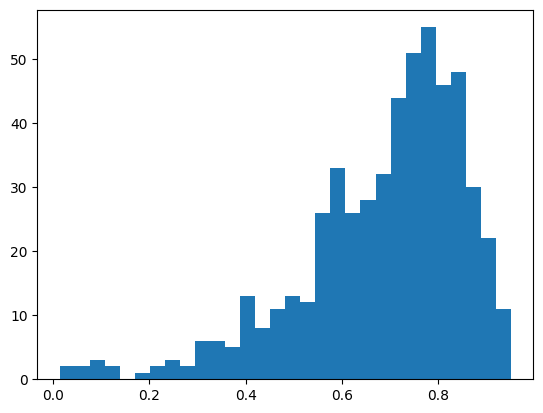

In [8]:
from matplotlib import pyplot as plt

plt.hist(calibrated_KGES[calibrated_KGES>0], bins = 30)
plt.show()

In [9]:
calibrated_KGES.mean()

0.6511377478097157

In [10]:
np.median(calibrated_KGES)

0.7165318169791439

In [11]:
calibrated_KGES

array([ 0.93864914,  0.81139841,  0.90589687,  0.85936885,  0.88780411,
        0.81618644,  0.78298278,  0.79292717,  0.86002109,  0.88580952,
        0.79435137,  0.83446906,  0.83976704,  0.78880728,  0.83806702,
        0.80829967,  0.82921377,  0.88030742,  0.67890756,  0.73124126,
        0.74209071,  0.84994678,  0.82068269,  0.7262751 ,  0.80621568,
        0.24722365,  0.7512313 ,  0.54888737,  0.62498752,  0.75104824,
        0.71824046,  0.76699311,  0.74987942,  0.70922746,  0.75042409,
        0.7886949 ,  0.70949958,  0.76904734,  0.83663774,  0.75796622,
        0.83484634,  0.4460498 ,  0.72880369,  0.5812842 ,  0.73906844,
        0.79976755,  0.86431163,  0.85086532,  0.75620529,  0.75563354,
        0.68497464,  0.75356664,  0.51069772,  0.57106986,  0.81610585,
        0.7689098 ,  0.73952573,  0.66851425,  0.80474854,  0.70714314,
        0.63099561,  0.59506833,  0.61608368,  0.7378529 ,  0.81673325,
        0.66710605,  0.76420138,  0.70263208,  0.55858068,  0.66